In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.contrib.eager as tfe

keras = tf.keras
tf.enable_eager_execution()

import matplotlib.pyplot as plt

In [2]:
from euler_self_tf import euler_self_tlist

# Oscillator as neural ODE (no control yet)

In [3]:
# oscillator as ODE within Keras
class odeModel_oscillator(tf.keras.Model):
    def __init__(self):
        self.A = tf.cast([[0, 1],[-1, -0.1]], tf.float32)

    def forward(self, t, y):
        return tf.matmul(y, self.A)

In [4]:
time_steps = 1000
t_grid = np.linspace(0, 100, time_steps)
y0_free = tf.cast([[5., 5.]], tf.float32)

free_trajectory = euler_self_tlist(odeModel_oscillator(), y0_free, t_grid, 1e-2)
free_trajectory = np.concatenate(free_trajectory)
free_trajectory.shape

(1000, 2)

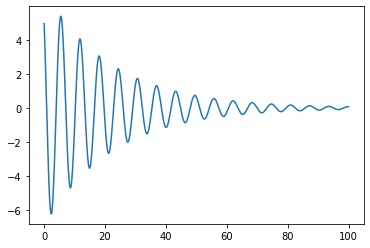

In [5]:
plt.plot(t_grid,free_trajectory[:,0])
plt.show()

# Oscillator with controller

In [6]:
# Oscillator with controller defined by neural network
class odeModel_oscillator_NNcontrol(tf.keras.Model):
    
    def __init__(self):
        super(odeModel_oscillator_NNcontrol, self).__init__()
        self.linear1 = keras.layers.Dense(50, activation="tanh")
        self.linear2 = keras.layers.Dense(1)
        self.A = tf.cast([[0, 1],[-1, -0.1]],tf.float32)
        
    def forward(self, t, y):
        con = self.linear1(y)
        con = self.linear2(con)
        free = tf.matmul(y, self.A)
        con = tf.concat([tf.zeros(con.shape),con],1)
        dy = tf.add(free, con)
        return dy

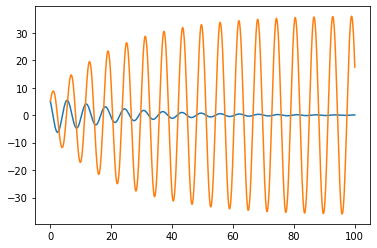

In [7]:
time_steps = 1000
t_grid = np.linspace(0, 100, time_steps)
y0 = tf.cast([[5., 5.]],tf.float32)

# Run forward evaluation
trajectory = euler_self_tlist(odeModel_oscillator_NNcontrol(), y0_free, t_grid, 1e-2)
trajectory = np.concatenate(trajectory)
free_trajectory = euler_self_tlist(odeModel_oscillator(), y0_free, t_grid, 1e-2)
free_trajectory = np.concatenate(free_trajectory)

plt.plot(t_grid,free_trajectory[:,0],t_grid, trajectory[:,1])

# Train

In [8]:
# model = odeModel_oscillator_NNcontrol()
# batch_y0 = tf.random_uniform([3,2], minval=-15.,maxval=15.)
# # model.forward(0,batch_y0).shape, batch_y0.shape
# # euler_self_tlist(model, batch_y0, t_grid, 1e-1).shape
# compute_gradients_and_update_path(batch_y0)

In [9]:
def get_batch(batch_size):
    return tf.random_uniform([50,2], minval=-15.,maxval=15.)

In [10]:
# Function for gradient evaluation and update
optimizer = tf.train.MomentumOptimizer(learning_rate=1e-5, momentum=0.95)

def compute_gradients_and_update_path(batch_y0):
    with tf.GradientTape() as g:
        
        y_points = euler_self_tlist(model, batch_y0, t_grid, 1e-1)
        pred_path = tf.stack(y_points)  # -> (batch_time, batch_size, 3) 
        loss = tf.reduce_mean(tf.math.square(pred_path), axis=1) # -> (batch_time, 2)   
        loss = tf.reduce_mean(loss, axis=0)
    
    gradients = g.gradient(loss, model.weights)  # tensorflow gradient computation
    optimizer.apply_gradients(zip(gradients, model.weights))
    return loss[0]

# compute_gradients_and_update_path = tfe.defun(compute_gradients_and_update_path) # this makes the code faster

tf.Tensor(58.702568, shape=(), dtype=float32)


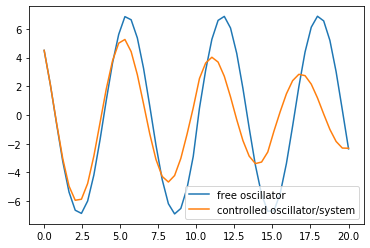

tf.Tensor(7.0219703, shape=(), dtype=float32)


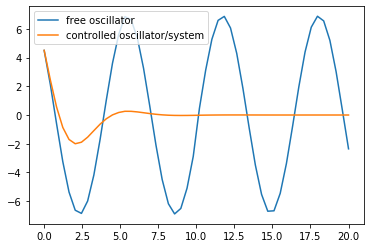

tf.Tensor(5.9090223, shape=(), dtype=float32)


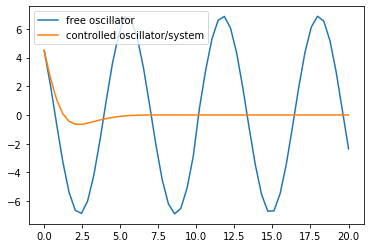

tf.Tensor(7.489109, shape=(), dtype=float32)


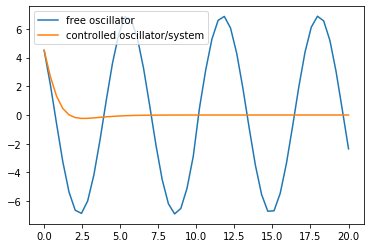

tf.Tensor(7.157379, shape=(), dtype=float32)


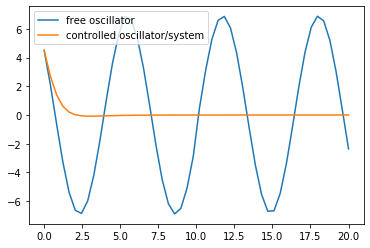

tf.Tensor(7.1662946, shape=(), dtype=float32)


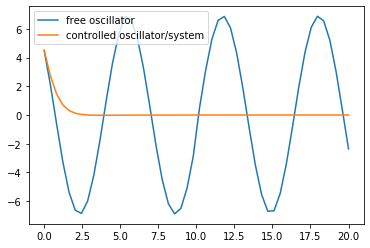

In [11]:
# Set up parameters
time_steps = 50
t_grid = np.linspace(0, 20, time_steps)

# Free system for comparison
free_trajectory = euler_self_tlist(odeModel_oscillator(), y0_free, t_grid, 1e-1)
free_trajectory = np.concatenate(free_trajectory)

# Initialise new instance of the model
model = odeModel_oscillator_NNcontrol()


batch_size = 20
niters = 100
test_freq = 20
loss_history = []

# Run simulation niters times, updating parameters on each iteration
for step in range(niters+1):
    
    batch_y0 = get_batch(batch_size) # Random
    
    loss = compute_gradients_and_update_path(batch_y0)    
    loss_history.append(loss.numpy())
    
    if step % test_freq == 0:        
        trajectory = euler_self_tlist(model, y0, t_grid, 1e-1)        
        print(loss)
        
        trajectory = np.concatenate(trajectory)
        plt.plot(t_grid, free_trajectory[:,0], t_grid, trajectory[:,0])
        plt.legend( ('free oscillator', 'controlled oscillator/system'))
        plt.show()

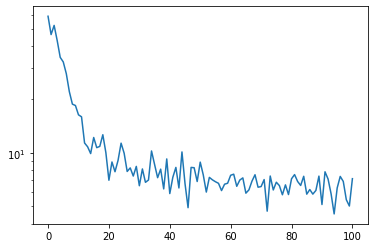

In [12]:
plt.plot(loss_history)
plt.yscale("log")